First, let's import all necessary libraries:

In [1]:
import collections
import logging
import numpy as np
import pickle
import pytorch_lightning as pl
import torch

from copy import deepcopy
from matplotlib import pyplot as plt
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.nn import BCEWithLogitsLoss
from tqdm.notebook import tqdm

from attacks import influence_attack
from datamodules import GermanCreditDatamodule, CompasDatamodule, DrugConsumptionDatamodule
from fairness import FairnessLoss
from trainingmodule import BinaryClassifier

logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

Now we create a **general attack function** that handles all different attack methods

In [2]:
def attack(dm, model, eps, lamda):
    # Create adversarial loss according to Mehrabi et al.
    bce_loss, fairness_loss = BCEWithLogitsLoss(), FairnessLoss(dm.get_sensitive_index())
    adv_loss = lambda _model, X, y, adv_mask: (
            bce_loss(_model(X), y.float()) + lamda * fairness_loss(X, *_model.get_params())
    )
    
    # Create new training pipeline to use in influence attack
    trainer = pl.Trainer(
        max_epochs=100,
        gpus=1 if torch.cuda.is_available() else 0,
        enable_model_summary=False,
        enable_progress_bar=False,
        log_every_n_steps=1,
        callbacks=[EarlyStopping(monitor="train_acc", mode="max", patience=10)]
    )

    poisoned_dataset = influence_attack(
        model=model,
        datamodule=dm,
        trainer=trainer,
        adv_loss=adv_loss,
        eps=eps,
        eta=0.01,
        attack_iters=100,
    )
    
    # Create deep copy of the original dataset and poison the copy
    dm = deepcopy(dm)
    dm.update_train_dataset(poisoned_dataset)

    return dm

and a **nested dictionary**, which is convinient to store results for multiple datasets and metrics:

In [3]:
def nested_dict():
   return collections.defaultdict(nested_dict)

results = nested_dict()

Finally, iterate over all possible combination of Figure 2 in Mehrabi et al.

In [4]:
# Create Datamodules for all datasets
german_credit_datamodule = GermanCreditDatamodule('data/', 10)
compas_datamodule = CompasDatamodule('data/', 50)
drug_consumption_datamodule = DrugConsumptionDatamodule('data/', 10)

# Create Trainer


for dm in [german_credit_datamodule, compas_datamodule, drug_consumption_datamodule]:
    for eps in [0, 0.1, 0.5, 1]:
        print(f'Poisoning {dm.get_dataset_name()} dataset with eps = {eps}:')
        for lamda in tqdm([0, 0.1, 0.2, 0.4, 0.6, 0.8, 1]):
            pl.seed_everything(123)
            
            metrics = {'test_error': [], 'SPD': [], 'EOD': []}
            for run in range(3):
                # Create a Binary Classifier model for each dataset
                model = BinaryClassifier('LogisticRegression', dm.get_input_size(), lr=1e-3)
                
                # Create poisoned dataset
                if eps == 0:
                    dm_poisoned = dm
                else:
                    dm_poisoned = attack(dm, model, eps, lamda)
                trainer = pl.Trainer(
                    max_epochs=300,
                    gpus=1 if torch.cuda.is_available() else 0,
                    enable_model_summary=False,
                    enable_progress_bar=False,
                    log_every_n_steps=1,
                    callbacks=[EarlyStopping(monitor="train_acc", mode="max", patience=10)]
                )
                
                # Train on the poisoned dataset
                trainer.fit(model, dm_poisoned)
                
                # Save Accuracy and Fairness metrics
                run_results = trainer.test(model, dm)[0]
                for metric, value in run_results:
                    metrics[metric].append(value)
                    
            # Save mean of metrics
            results[dm.get_dataset_name()]['Test Error'][eps]['mean'][lamda] = np.mean(metrics['test_error'])
            results[dm.get_dataset_name()]['Statistical Parity'][eps]['mean'][lamda] = np.mean(metrics['SPD'])
            results[dm.get_dataset_name()]['Equality of Opportunity'][eps]['mean'][lamda] = np.mean(metrics['EOD'])
            
            # Save standard deviation of metrics
            results[dm.get_dataset_name()]['Test Error'][eps]['std'][lamda] = np.std(metrics['test_error'])
            results[dm.get_dataset_name()]['Statistical Parity'][eps]['std'][lamda] = np.std(metrics['SPD'])
            results[dm.get_dataset_name()]['Equality of Opportunity'][eps]['std'][lamda] = np.std(metrics['EOD'])
            
            # for eps = 0 run the experiment only with lambda = 0
            if eps == 0:
                break
            
with open('different-attacks.pkl', 'wb') as f:
    pickle.dump(results, f)

Poisoning German Credit dataset with eps = 0:


  0%|          | 0/7 [00:00<?, ?it/s]

Poisoning German Credit dataset with eps = 0.1:


  0%|          | 0/7 [00:00<?, ?it/s]

Poisoning German Credit dataset with eps = 1:


  0%|          | 0/7 [00:00<?, ?it/s]

Poisoning COMPAS dataset with eps = 0:


  0%|          | 0/7 [00:00<?, ?it/s]

Poisoning COMPAS dataset with eps = 0.1:


  0%|          | 0/7 [00:00<?, ?it/s]

Poisoning COMPAS dataset with eps = 1:


  0%|          | 0/7 [00:00<?, ?it/s]

Poisoning Drug Consumption dataset with eps = 0:


  0%|          | 0/7 [00:00<?, ?it/s]

Poisoning Drug Consumption dataset with eps = 0.1:


  0%|          | 0/7 [00:00<?, ?it/s]

Poisoning Drug Consumption dataset with eps = 1:


  0%|          | 0/7 [00:00<?, ?it/s]

and plot results:

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

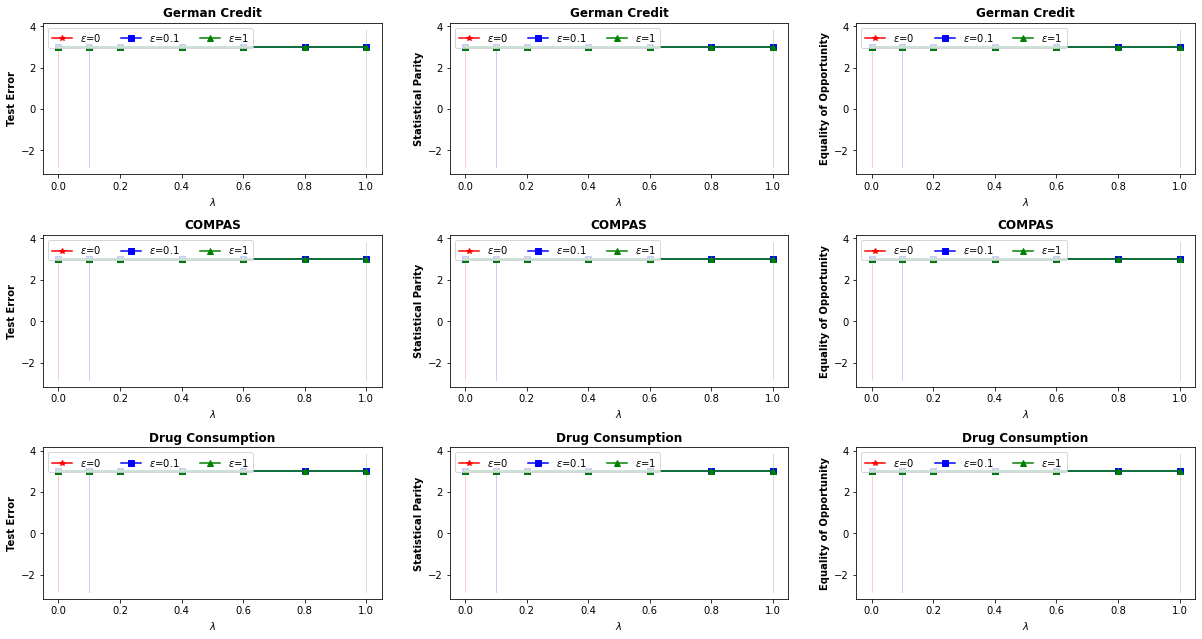

In [5]:

# Reproduce plot styling of the original paper
colors, markers = ['r', 'b', 'g'], ['*', 's', '^']

fig, ax = plt.subplots(3, 3, figsize=(20, 10))
for i, dataset in enumerate(['German Credit', 'COMPAS', 'Drug Consumption']):
    for j, metric in enumerate(['Test Error', 'Statistical Parity', 'Equality of Opportunity']):
        for k, eps in enumerate([0, 0.1, 1]):
            lamda = np.array(list(results[dataset][metric][eps]['mean'].keys()))
            mean = np.array(list(results[dataset][metric][eps]['mean'].values()))
            std = np.array(list(results[dataset][metric][eps]['std'].values()))
            
            ax[i, j].plot(lamda, mean, c=colors[k], marker=markers[k], label='$\epsilon$' + f'={eps}')
            ax[i, j].fill_between(eps, lamda-2*std, lamda+2*std, color=colors[k], alpha=0.2)
        
        ax[i, j].set_xlabel('$\lambda$', fontweight='bold')
        ax[i, j].set_ylabel(metric, fontweight='bold')
        ax[i, j].set_title(dataset, fontweight='bold')
        ax[i, j].legend(loc='upper left', ncol=3)
        
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.4)
plt.savefig('different-attacks.eps')